<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/CNN_boot_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traininig NN Spectrum

# Loading Necesary Libraries

In [29]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
from tqdm import tqdm

from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [2]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [3]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Create training/testing df

In [ ]:
def rand(start, end, num): # get random value function
    res = []
    for j in range(num):
        res.append(np.random.randint(start, end))
    return res

In [ ]:
def calc_freq_behavior(working_df, selected_point, multi=False): # Individual freq calculator
  extra_data = working_df.iloc[:, 0:6]
  freq_selected = working_df.iloc[:, selected_point+6]

  freq_data_df = pd.merge(extra_data, freq_selected, left_index=True, right_index=True)
  freq_data_df['Distance_km'] = freq_data_df['Distance_km'].astype(int)

  headers = list(freq_data_df.columns.values)
  selected_val = round(float(headers[-1]), 5)

  distances = [x*80 for x in range(1, 26)]
  freq_behavior = {}
  f_behavior = {}

  for dist in distances: # loop all distances available

    distance_df = freq_data_df[(freq_data_df['Distance_km'] == dist)] # select all the row with current eval distance
    freq_distance_vals = distance_df[str(selected_val)].tolist()

    freq_mean = np.mean(freq_distance_vals)
    freq_std = np.std(freq_distance_vals)
    results = (freq_mean, freq_std)
    f_behavior[dist] = results

  freq_behavior[selected_val] = f_behavior
  return freq_behavior

In [ ]:
def select_eval_cols(working_df, eval_cols_param): # retturn index of column to be evaluated
  if eval_cols_param[0] == 'even': 
    break_point = int((working_df.shape[1]-6)/(eval_cols_param[1]+1))
    selected_cols = []
    for col_idx in range(1, eval_cols_param[1]+1):
      selected_cols.append((col_idx*break_point)-1)
  else:
    selected_cols = rand(1, working_df.shape[1]-6, eval_cols_param[1])
    selected_cols = sorted(selected_cols)
  return selected_cols

In [ ]:
# multi_params = (method, number_freq_to_analyze)
def multiple_freq_analyzer(working_df, multi_params): #method = 'rand' or 'even' (multiple freq behavior calculator)
  selected_cols = select_eval_cols(working_df, multi_params)

  multi_freq_behavior = {}
  for selected_point in tqdm(selected_cols):
    freq_behavior = calc_freq_behavior(working_df, selected_point)
    selected_v = [v for v in freq_behavior.keys()]

    selected_d = {}
    for data in freq_behavior.values():
      for k, v in data.items():
        selected_d[k] = v

    multi_freq_behavior[selected_v[0]] = selected_d
  return multi_freq_behavior

In [ ]:
def freq_dict_to_df(multi_freq_behavior):
  distances = [x*80 for x in range(1, 26)]
  freq_mean_data = {'distances':distances}
  freq_std_data = {'distances':distances}

  for header, distances_dict in multi_freq_behavior.items():
    col_data_mean = []
    col_data_std = []
    for distance, results in distances_dict.items():
      col_data_mean.append(results[0])
      col_data_std.append(results[1])
    freq_mean_data[header] = col_data_mean
    freq_std_data[header] = col_data_std

  freq_mean_df = pd.DataFrame(freq_mean_data)
  freq_std_df = pd.DataFrame(freq_std_data)
  
  return freq_mean_df, freq_std_df

## Pearson Correletion

In [ ]:
#eval_method = 'avg' or 'min' or 'max'

def pearson_matrix(working_df , source_sample_id):
  distances = [x*80 for x in range(1, 26)]
  result_data = {'source/target': distances}
  
  for target_dist in tqdm(distances): # loop all distances available
    min_result_target = []
    avg_result_target = []
    max_result_target = []
    for source_dist in distances: # loop all distances available
      source_df = working_df[(working_df['Distance_km'] == source_dist) & (working_df['PBRS_id'] == source_sample_id)]# select data of source (distance and sample_id) 
      source_data = source_df.iloc[0, 6:source_df.shape[1]].tolist()
      pearson_values = []
      for target_sample_id in working_df['PBRS_id'].unique(): # loop all samples id to then exclude the source sample id
        if target_sample_id != source_sample_id:
          target_df = working_df[(working_df['Distance_km'] == target_dist) & (working_df['PBRS_id'] == target_sample_id)] # select data of target
          target_data = target_df.iloc[0, 6:target_df.shape[1]].tolist()
          pearson_values.append(round(pearsonr(source_data, target_data)[0], 5)) # pearson correlation
      
      avg_result_target.append(np.mean(pearson_values))    
      max_result_target.append(np.max(pearson_values))
      min_result_target.append(np.min(pearson_values))
      
    result_data['min_'+str(target_dist)] = min_result_target
    result_data['avg_'+str(target_dist)] = avg_result_target
    result_data['max_'+str(target_dist)] = max_result_target

  pearson_matrix_df = pd.DataFrame.from_dict(result_data)
  #pearson_matrix_df = pearson_matrix_df.set_index('source/target')

  return pearson_matrix_df, result_data

## Mean/std analysis

In [ ]:
def calc_freq_behavior(working_df, selected_point): # Individual freq calculator
  extra_data = working_df.iloc[:, 0:6]
  freq_selected = working_df.iloc[:, selected_point+6]

  freq_data_df = pd.merge(extra_data, freq_selected, left_index=True, right_index=True)
  freq_data_df['Distance_km'] = freq_data_df['Distance_km'].astype(int)

  headers = list(freq_data_df.columns.values)
  selected_val = round(float(headers[-1]), 5)

  distances = [x*80 for x in range(1, 26)]
  freq_behavior = {}
  f_behavior = {}

  for dist in distances: # loop all distances available

    distance_df = freq_data_df[(freq_data_df['Distance_km'] == dist)] # select all the row with current eval distance
    freq_distance_vals = distance_df[str(selected_val)].tolist()

    freq_mean = np.mean(freq_distance_vals)
    freq_std = np.std(freq_distance_vals)
    results = (freq_mean, freq_std)
    f_behavior[dist] = results
  freq_behavior[selected_val] = f_behavior
  return freq_behavior

In [ ]:
def calc_freq_behavior_v2(working_df, amt_of_selected_point): # Individual freq calculator
  extra_data = working_df.iloc[:, 0:6]

  distances = [x*80 for x in range(1, 26)]

  std_combined = []
  for dist in distances: # loop all distances available
    std_all = []
    for val_idx in range(0, amt_of_selected_point):

      freq_selected = working_df.iloc[:, val_idx+6]
      freq_data_df = pd.merge(extra_data, freq_selected, left_index=True, right_index=True)
      freq_data_df['Distance_km'] = freq_data_df['Distance_km'].astype(int)

      headers = list(freq_data_df.columns.values)
      selected_val = round(float(headers[-1]), 5)
      
      distance_df = freq_data_df[(freq_data_df['Distance_km'] == dist)] # select all the row with current eval distance
      freq_distance_vals = distance_df[str(selected_val)].tolist()

      freq_std = np.std(freq_distance_vals)
      std_all.append(freq_std)
      std_avg = round(np.average(std_all), 5)
    std_combined.append(std_avg)


  data = {'source/target':distances, 'std':std_combined}
 
  # Create DataFrame
  std_df = pd.DataFrame(data)
  return std_df

In [ ]:
# Get features 
def get_features(eval_freq_data_df, amt_sel_points):
  # get pearson values
  pearson_matrix_df, result_data = pearson_matrix(eval_freq_data_df, source_sample_id=1)

  # get std values
  std_df = calc_freq_behavior_v2(eval_freq_data_df, amt_of_selected_point = amt_sel_points)

  final_df = pd.merge(pearson_matrix_df, std_df, on = "source/target", how = "inner")
  return final_df

In [ ]:
def train_test_split(working_df, amt_train = 0.8):
  print('Creating train/test split:')
  num_sample_train = math.ceil((working_df.shape[1]-6)*amt_train)
  num_sample_test = (working_df.shape[1]-6) - num_sample_train

  multi_params = ('rand', num_sample_train)  # (evenly separate points(other option 'rand'for randomly selected points), mount of points to be selected)
  multi_freq_behavior = multiple_freq_analyzer(working_df, multi_params)

  eval_points = select_eval_cols(working_df, multi_params) # get indexes of of points to be evaluated
  real_eval_idx = [eval_point+6 for eval_point in eval_points]

  extra_data = working_df.iloc[:, 0:6]
  eval_freq_df = working_df.iloc[:, real_eval_idx]
  train_df = pd.merge(extra_data, eval_freq_df, left_index=True, right_index=True) #df we only eval freqs TRAIN

  test_df= working_df.copy()
  test_df.drop(test_df.columns[real_eval_idx], axis=1, inplace=True) # df without eval freqs TEST
  return train_df, test_df

## Run train/test split

In [ ]:
input_path = path + "/Spectrum/CNN/working_df.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

train_df, test_df = train_test_split(working_df, amt_train = 0.8)

Creating train/test split:


100%|██████████| 1654/1654 [00:27<00:00, 60.18it/s]


In [ ]:

print('------------------------------')
# Get features 
print('Calculating features for train set:')
train_features_df = get_features(train_df, train_df.shape[1]-6)
print('------------------------------')
print('Calculating features for test set:')
test_features_df = get_features(test_df, test_df.shape[1]-6)

------------------------------
Calculating features for train set:


100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


------------------------------
Calculating features for test set:


100%|██████████| 25/25 [00:12<00:00,  1.94it/s]


In [ ]:
train_features_df.to_csv(path+'/Spectrum/CNN/training_data_DNN.csv', index=False)

In [ ]:
test_features_df.to_csv(path+'/Spectrum/CNN/testing_data_DNN.csv', index=False)

#New Train/Test Split

In [ ]:
input_path = path + "/Spectrum/CNN/working_df.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

In [ ]:
print(working_df.shape)

(325, 2073)


In [ ]:
excluding_model_data_df = working_df.loc[working_df['PBRS_id'] != 1]

In [ ]:
model_data_df = working_df.loc[working_df['PBRS_id'] == 1]
model_dict = {}
for row in range(model_data_df.shape[0]):
  distance = working_df.iloc[row,3]
  values = np.array(working_df.iloc[row,6:working_df.shape[1]])
  model_dict[distance] = values

In [ ]:
def get_idx_train_test_split(working_df, trainingProp = 0.8):
  rows_mixed=np.random.permutation(working_df.shape[0])

  training_amt = math.ceil(working_df.shape[0]*trainingProp)
  testing_amt = working_df.shape[0] - training_amt

  rows_training = rows_mixed[:training_amt]
  rows_testing = rows_mixed[-testing_amt:]

  return rows_training, rows_testing

In [ ]:
rows_training, rows_testing = get_idx_train_test_split(excluding_model_data_df, trainingProp = 0.8)

In [ ]:
def get_features(excluding_model_data_df, selected_rows):

  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []

  for row_idx in selected_rows:
    data_Y = excluding_model_data_df.iloc[row_idx,3]
    data_X = np.array(excluding_model_data_df.iloc[row_idx,6:excluding_model_data_df.shape[1]])
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    pearson_vals = []
    for k, v in model_dict.items():  
      pearson_vals.append(round(pearsonr(v, data_X)[0], 5))

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

  data = {'distance':data_distance,
                  'mean':data_mean,
                  'std':data_std,
                  'pearson_min':data_pearson_min,
                  'pearson_mean':data_pearson_mean,
                  'pearson_max':data_pearson_max}

  data_df = pd.DataFrame(data)

  return data_df

In [ ]:
training_df = get_features(excluding_model_data_df, rows_training)

testing_df = get_features(excluding_model_data_df, rows_testing)

# Bootstrapping

In [4]:
input_path = path + "/Spectrum/CNN/working_df.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

In [5]:
working_df

,row,PBRS_id,Channels,Distance_km,power_dBm,#span,-32.15625,-32.125,-32.09375,-32.0625,...,32.125,32.15625,32.1875,32.21875,32.25,32.28125,32.3125,32.34375,32.375,32.40625
0,1,1,1,80,0,1,-14.851402,-21.638525,-23.529105,-14.969324,...,-19.957216,-19.447732,-14.576655,-15.491358,-14.654316,-17.801658,-16.387551,-13.980891,-15.122689,-17.753853
1,2,1,1,160,0,2,-32.415520,-23.442737,-17.642596,-16.382163,...,-15.348137,-13.125596,-15.424900,-18.560355,-17.197693,-12.466164,-12.735882,-10.007690,-13.820587,-21.908636
2,3,1,1,240,0,3,-23.428437,-21.738735,-19.956032,-18.320372,...,-21.210045,-20.014100,-13.636612,-9.728106,-7.977970,-19.904029,-22.658427,-19.765777,-24.603827,-31.921519
3,4,1,1,320,0,4,-14.298403,-15.210905,-15.951684,-16.209202,...,-18.673789,-12.470911,-12.638057,-9.282286,-12.488977,-10.933173,-15.749634,-15.676254,-15.412170,-14.347517
4,5,1,1,400,0,5,-19.455200,-19.755724,-18.313774,-13.272877,...,-17.697814,-16.074418,-16.232349,-13.788018,-22.471867,-23.016590,-22.392253,-18.544159,-18.765642,-23.196090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,321,13,1,1680,0,21,-31.466739,-32.655263,-31.882492,-27.589879,...,-34.359245,-32.466935,-29.543434,-31.321699,-33.322457,-34.343455,-30.096108,-33.185712,-33.367392,-33.876192
321,322,13,1,1760,0,22,-21.303913,-33.080588,-37.034437,-31.766035,...,-32.977742,-28.624796,-27.495186,-23.847968,-25.561252,-34.242901,-40.735728,-34.014182,-33.957388,-35.627786
322,323,13,1,1840,0,23,-27.601906,-27.758137,-27.102083,-27.319948,...,-33.646975,-25.620092,-34.883694,-42.119980,-35.870338,-28.109018,-32.237494,-32.837088,-31.096978,-25.976283
323,324,13,1,1920,0,24,-31.725625,-38.937830,-39.113483,-26.640446,...,-21.790284,-24.651905,-26.129703,-26.548903,-25.567147,-30.324506,-30.829273,-33.027456,-34.010274,-34.402337


In [6]:
distances = [x*80 for x in range(1, 26)]

In [41]:
working_df.shape

(325, 2073)

In [71]:
def get_max_min_val_col(working_df):
  max_min_col_dict = {'distance':[],
                      'column':[],
                      'min_max':[]}
  for d in tqdm(distances):
    max_min_col_dict['distance'].append(d)
    boot_dist_df = working_df.loc[working_df['Distance_km'] == d]
    for idx in range(6, boot_dist_df.shape[1]):
      max_val_col = float(boot_dist_df.iloc[:, [idx]].max()) # max val in col
      min_val_col = float(boot_dist_df.iloc[:, [idx]].min()) # min val in col
      h = boot_dist_df.iloc[:, [idx]].columns # header of col
      h = h[0]
      max_min_col_dict['column'].append(h)
      max_min_col_dict['min_max'].append((min_val_col, max_val_col))
  return max_min_col_dict

In [72]:
max_min_col_dict = get_max_min_val_col(working_df)

 16%|█▌        | 4/25 [00:14<01:18,  3.73s/it]


KeyboardInterrupt: ignored

In [66]:
max_min_col_dict

{'column': ['-32.15625',
  '-32.125',
  '-32.09375',
  '-32.0625',
  '-32.03125',
  '-32.0',
  '-31.96875',
  '-31.9375',
  '-31.90625',
  '-31.875',
  '-31.84375',
  '-31.8125',
  '-31.78125',
  '-31.75',
  '-31.71875',
  '-31.6875',
  '-31.65625',
  '-31.625',
  '-31.59375',
  '-31.5625',
  '-31.53125',
  '-31.5',
  '-31.46875',
  '-31.4375',
  '-31.40625',
  '-31.375',
  '-31.34375',
  '-31.3125',
  '-31.28125',
  '-31.25',
  '-31.21875',
  '-31.1875',
  '-31.15625',
  '-31.125',
  '-31.09375',
  '-31.0625',
  '-31.03125',
  '-31.0',
  '-30.96875',
  '-30.9375',
  '-30.90625',
  '-30.875',
  '-30.84375',
  '-30.8125',
  '-30.78125',
  '-30.75',
  '-30.71875',
  '-30.6875',
  '-30.65625',
  '-30.625',
  '-30.59375',
  '-30.5625',
  '-30.53125',
  '-30.5',
  '-30.46875',
  '-30.4375',
  '-30.40625',
  '-30.375',
  '-30.34375',
  '-30.3125',
  '-30.28125',
  '-30.25',
  '-30.21875',
  '-30.1875',
  '-30.15625',
  '-30.125',
  '-30.09375',
  '-30.0625',
  '-30.03125',
  '-30.0',
  '-29.

In [58]:
num_of_ne_samples = 1
import random

row_data = []
PBRS_id_data = []
Distance_km_data = []
power_dBm_data = []
span_data = []

#data_working_df = working_df.iloc[:, 6:working_df.shape[1]]
h_list = list(working_df.columns.values)
new_data = {header:[] for header in h_list}


last_row_in_old_df_val = working_df.shape[0]
for new_sample in range(num_of_ne_samples): # generating (num_of_ne_samples) new samples for en data
  print('Adding sample: '+str(new_sample+1))
  for d in tqdm(distances):
    new_data['row'].append(last_row_in_old_df_val)
    #row_data.append(last_row_in_old_df_val)
    last_row_in_old_df_val += 1
    new_data['PBRS_id'].append(new_sample+14)
    #PBRS_id_data.append(new_sample)
    new_data['Channels'].append(1)
    #power_dBm_data.append(0)

    new_data['Distance_km'].append(d)
    #Distance_km_data.append(d)
    new_data['power_dBm'].append(0)
    new_data['#span'].append(int(d/80))
    #span_data.append(int(d/80))

    boot_dist_df = working_df.loc[working_df['Distance_km'] == d]
    #boot_dist_df.iloc[:, [1]].max()
    for idx in range(6, boot_dist_df.shape[1]):
      max_val_col = float(boot_dist_df.iloc[:, [idx]].max()) # max val in col
      min_val_col = float(boot_dist_df.iloc[:, [idx]].min()) # min val in col
      h = boot_dist_df.iloc[:, [idx]].columns # header of col
      h = h[0]

      bootstrap_val = round(random.uniform(min_val_col, max_val_col), 14)
      new_data[h].append(bootstrap_val)
      
      
      
print(new_data)

Adding sample: 1


 24%|██▍       | 6/25 [00:25<01:21,  4.27s/it]


KeyboardInterrupt: ignored

# Neural Network

## Pre-processing

In [ ]:
#training_df=pd.read_csv(path+'/Spectrum/CNN/training_data_DNN.csv')

Y = training_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = training_df.iloc[:, 1:training_df.shape[1]]

sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_train = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_train = sc_input.fit_transform(X) # convert features to values from 0 to 1

## Model

In [ ]:
'''
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(76, input_dim = 76, activation = 'tanh'))
    model.add(Dense(38,activation='tanh'))
    model.add(Dense(19,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time
'''

"\nfrom keras.models import Sequential\nfrom keras.layers import Dense,Conv2D, Flatten\nfrom keras.wrappers.scikit_learn import KerasRegressor\nfrom keras.callbacks import EarlyStopping\n\n\ndef ann():\n    model = Sequential()\n    model.add(Dense(76, input_dim = 76, activation = 'tanh'))\n    model.add(Dense(38,activation='tanh'))\n    model.add(Dense(19,activation='tanh'))\n    model.add(Dense(1))\n    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')\n    return model\n\n\nmodel_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32)\n\nstart_time = time.time()\ncallback = EarlyStopping(monitor='loss', patience=500)\nmodel_ann.fit(X_train, Y_train, callbacks=[callback])\ntime_train_ann = time.time() - start_time\n"

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(60, input_dim = 5, activation = 'relu'))
    model.add(Dense(30,activation='relu'))
    model.add(Dense(20,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 3ms/step - loss: 0.0643
Epoch 2502/5000
8/8 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 2503/5000
8/8 [==============================] - 0s 3ms/step - loss: 0.0608
Epoch 2504/5000
8/8 [==============================] - 0s 3ms/step - loss: 0.0624
Epoch 2505/5000
8/8 [==============================] - 0s 2ms/step - loss: 0.0616
Epoch 2506/5000
8/8 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 2507/5000
8/8 [==============================] - 0s 3ms/step - loss: 0.0637
Epoch 2508/5000
8/8 [==============================] - 0s 2ms/step - loss: 0.0605
Epoch 2509/5000
8/8 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 2510/5000
8/8 [==============================] - 0s 2ms/step - loss: 0.0624
Epoch 2511/5000
8/8 [==============================] - 0s 3ms/step - loss: 0.0613
Epoch 2512/5000
8/8 [==============================] - 0s 2ms/s

## Test Model

In [ ]:
#testing_df=pd.read_csv(path+'/Spectrum/CNN/testing_data_DNN.csv')

Y = testing_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = testing_df.iloc[:, 1:testing_df.shape[1]]


sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_test = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_test = sc_input.fit_transform(X) # convert features to values from 0 to 1

[0.25929248, 0.18676877, 0.7032686, 0.084099084, 0.77219677, 0.98252606, 0.14736459, 0.7657391, 0.47753444, 0.01272434, 0.0114531815, 0.03068608, 0.09691301, 0.60679114, 0.0845246, 0.29663968, 0.50985223, 0.20499885, 0.3406582, 0.09517932, 0.5376806, 0.021392703, 0.023889363, 0.79736316, 0.09560612, 0.7734599, 0.5830244, 0.22220477, 0.44390616, 0.111594915, 0.7364601, 0.41372865, 0.36155877, 0.07985303, 0.25991058, 0.011995643, 0.06260097, 0.023219287, 0.96483046, 0.13927943, 0.42967516, 0.5609123, 0.5412076, 0.8640728, 0.27263582, 0.1733869, 0.7473936, 0.6956934, 0.7356851, 0.5889945, 0.5830326, 0.0026152134, 0.43041804, 0.6069633, 0.083324105, 0.20545885, 0.622266, 0.18649265, 0.72221076, 0.011699647]
[0.5652173913043479, 0.6521739130434783, 1.0, 0.43478260869565216, 0.08695652173913043, 0.13043478260869565, 0.2608695652173913, 0.5652173913043479, 0.17391304347826086, 0.8260869565217392, 0.43478260869565216, 0.391304347826087, 0.9565217391304348, 0.0, 0.5217391304347827, 0.4347826086

,dist,pred,error
0,1200,637.098145,0.469085
1,1360,503.654541,0.629666
2,2000,1454.014160,0.272993
3,960,314.742310,0.672143
4,320,1580.842041,3.940131
5,400,1967.847900,3.919620
6,640,431.150848,0.326327
7,1200,1568.959961,0.307467
8,480,1038.663330,1.163882
9,1680,183.412781,0.890826


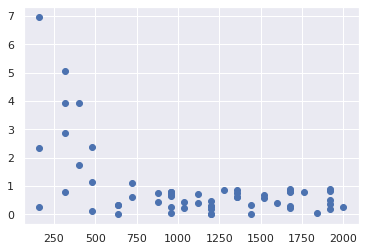

In [ ]:
start_time = time.time()
Y_test_pred=model_ann.predict(X_test)

time_eval_ann=time.time()-start_time

real=list(list(zip(*Y_test))[0])

#real=list(map(list, zip(*Y_train)))
pred=list(Y_test_pred)
print(pred)

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

#np.add = add values in a array
#np.multiply multiple values in a array
print(real)
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
#print(real_abs)
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar
#print(pred_abs)

#np.divide = divide values in a array
error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))

res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res.to_csv("results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()